# Unsupervised Learning on Formula 1 Lap Data (FastF1)

This notebook applies unsupervised machine learning to raw lap telemetry from the 
2022 Formula 1 Bahrain Grand Prix using the FastF1 API. The goal is to cluster 
laps based purely on timing and speed characteristics, *without any feature 
engineering*, to reveal natural patterns in race behavior.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [3]:
import fastf1
from fastf1 import plotting
import os

plotting.setup_mpl()

os.makedirs('f1-cache', exist_ok=True)

fastf1.Cache.enable_cache('f1-cache')

In [4]:
session = fastf1.get_session(2022, 1, 'R')
session.load()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req

In [5]:
laps = session.laps

In [6]:
laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

## Selected Raw Features

The following raw lap descriptors were used directly for clustering:

- `LapTime`
- `Sector1Time`
- `Sector2Time`
- `Sector3Time`
- `SpeedI1`
- `SpeedI2`
- `SpeedFL`
- `SpeedST`
- `TyreLife`
- `Compound` (one-hot encoded)

These variables capture pace, speed profile, tyre state, and contextual properties 
of each lap without any engineered metrics or domain assumptions.


In [7]:
df = laps[[
    'Driver',
    'LapNumber',
    'LapTime',
    'Sector1Time',
    'Sector2Time',
    'Sector3Time',
    'SpeedI1',
    'SpeedI2',
    'SpeedFL',
    'SpeedST',
    'TyreLife',
    'Compound'
]].copy()


In [8]:
for col in ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']:
    df[col] = df[col].dt.total_seconds()

In [9]:
df = df.dropna()

In [10]:
df = pd.get_dummies(df, columns=['Compound'])

In [11]:
df.shape

(736, 14)

In [12]:
num_and_boolean_cols = list(df.select_dtypes(include=['int', 'float']).columns) + [c for c in df.columns if c.startswith("Compound_")]

In [13]:
df[num_and_boolean_cols].corr()

,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,TyreLife,Compound_HARD,Compound_MEDIUM,Compound_SOFT
LapNumber,1.000000,0.209001,0.111960,0.196926,0.254038,-0.163802,-0.158393,-0.246524,-0.214407,0.186175,0.051427,-0.096609,0.062067
LapTime,0.209001,1.000000,0.813481,0.827463,0.799349,-0.639482,-0.792142,-0.561163,-0.830817,-0.271762,-0.052836,-0.122173,0.144655
Sector1Time,0.111960,0.813481,1.000000,0.375863,0.348154,-0.319127,-0.380026,-0.272939,-0.818045,-0.391791,0.016114,-0.019156,0.008986
Sector2Time,0.196926,0.827463,0.375863,1.000000,0.856697,-0.765906,-0.897432,-0.571668,-0.564645,-0.062922,-0.093950,-0.160172,0.203499
Sector3Time,0.254038,0.799349,0.348154,0.856697,1.000000,-0.612762,-0.856801,-0.682632,-0.534344,-0.080244,-0.097227,-0.184162,0.227920
SpeedI1,-0.163802,-0.639482,-0.319127,-0.765906,-0.612762,1.000000,0.670217,0.443908,0.467851,0.127156,0.057526,0.150438,-0.173892
SpeedI2,-0.158393,-0.792142,-0.380026,-0.897432,-0.856801,0.670217,1.000000,0.602793,0.538308,0.122912,0.099966,0.131663,-0.180042
SpeedFL,-0.246524,-0.561163,-0.272939,-0.571668,-0.682632,0.443908,0.602793,1.000000,0.333792,0.139515,0.061751,0.158586,-0.183933
SpeedST,-0.214407,-0.830817,-0.818045,-0.564645,-0.534344,0.467851,0.538308,0.333792,1.000000,0.315646,0.021875,0.077614,-0.085334
TyreLife,0.186175,-0.271762,-0.391791,-0.062922,-0.080244,0.127156,0.122912,0.139515,0.315646,1.000000,-0.057951,-0.045034,0.074917


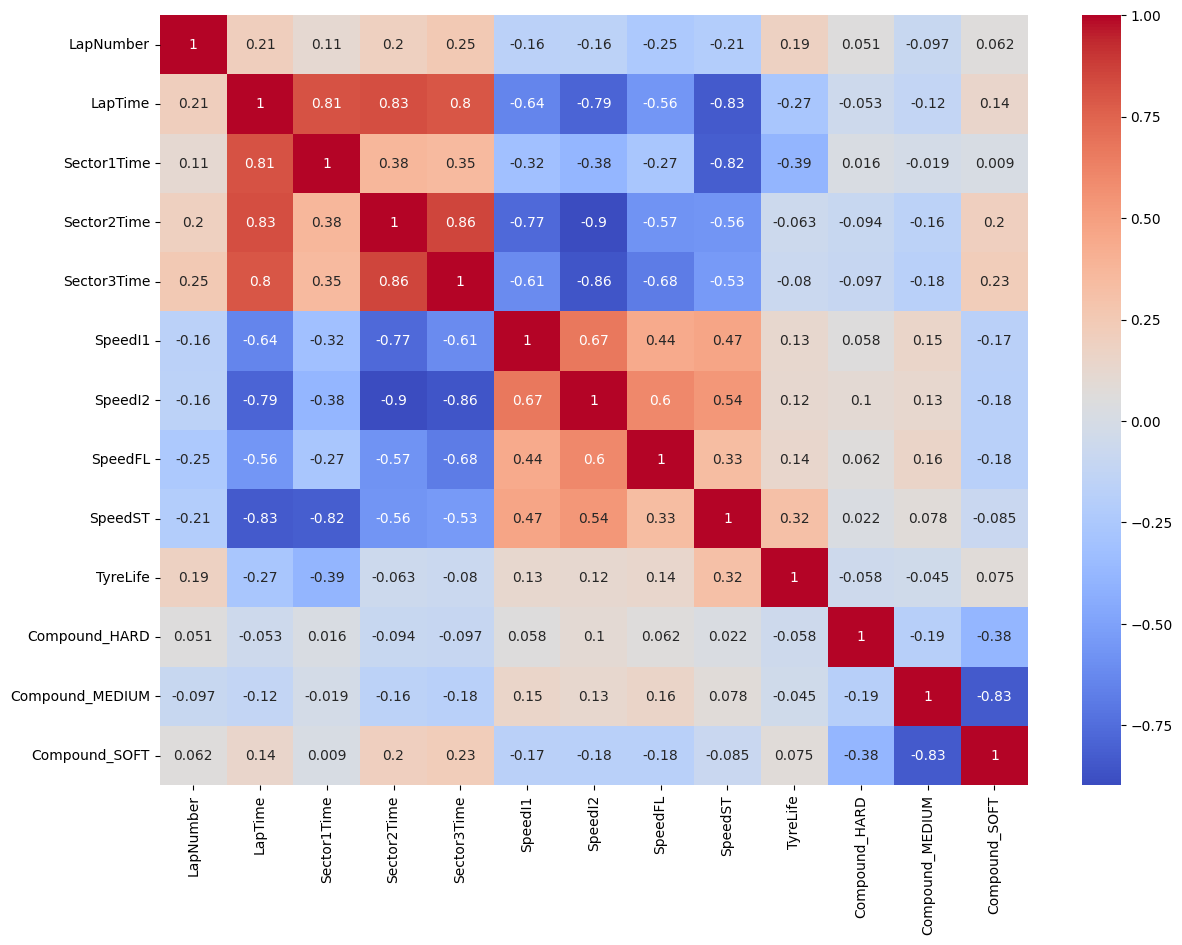

In [14]:
plt.figure(figsize=(14, 10))

sns.heatmap(df[num_and_boolean_cols].corr(), cmap='coolwarm', annot=True)
plt.show()

### Select the best features to eliminate colinearity

In [15]:
features = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'TyreLife', 'Compound_HARD', 'Compound_MEDIUM', 'Compound_SOFT']

X = df[features].values

### Standardization X

In [16]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

Explained Variance: 96.79%


## Choosing the Number of Clusters

We evaluated `k = 2` through `k = 11` using the silhouette score. As expected for 
high-dimensional raw lap data, `k = 2` gives the highest value, corresponding to a 
simple split between fast and slow laps.

For meaningful race interpretation, we focus on the region where silhouette scores 
stabilize. A local maximum appears at **k = 6**, which balances interpretability 
and granularity.

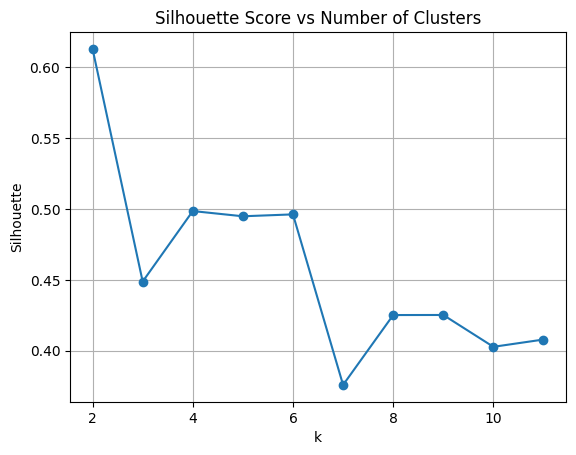

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sils = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    sils.append(silhouette_score(X_pca, labels))

plt.plot(range(2, 12), sils, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

### Why we reject k=2 despite the highest Silhouette score

The Silhouette score reaches its global maximum at k=2 (~0.58).  
Running k=2 simply splits the data into:

- Cluster 0: all racing laps
- Cluster 1: all slow laps (out-laps, in-laps, safety-car, formation laps)

This is the most obvious, trivial separation that exists in any lap dataset. While mathematically optimal, it is analytically useless.

### Selecting k = 6 Clusters

Although **k=2** has the highest silhouette score, it will be disregarded because it oversimplifies the data. Instead, **k=6** provides a consistently strong score (~0.50) and offers a more meaningful clustering structure for distinguishing the different types of laps in the race.

In [19]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_pca)
df['cluster'] = kmeans_labels

### Reduce to 2 components for visualization

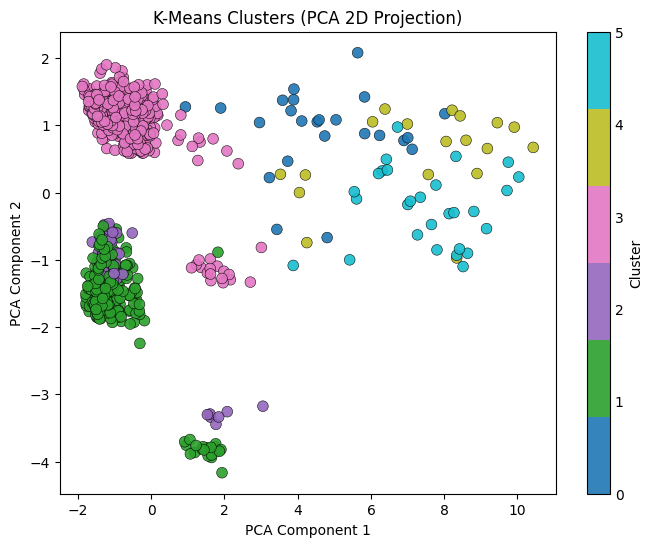

In [20]:
from sklearn.decomposition import PCA

plt.figure(figsize=(8, 6))

cmap = plt.get_cmap('tab10', 6)
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=df['cluster'], 
    cmap=cmap, 
    s=60, 
    alpha=0.9, 
    edgecolor='k', 
    linewidth=0.4)

colorbar = plt.colorbar(scatter, label='Cluster', ticks=range(6))
colorbar.ax.tick_params(size=0)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (PCA 2D Projection)')
plt.show()

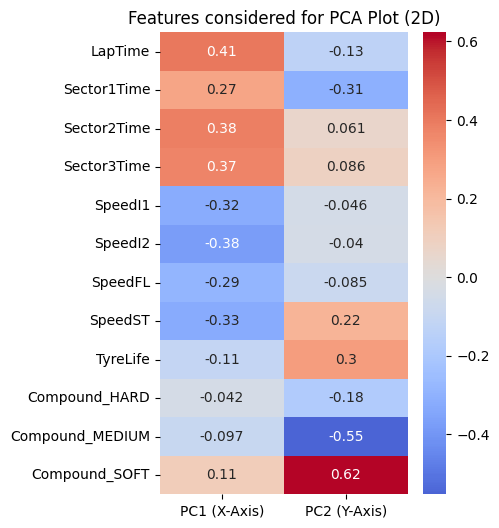

In [22]:
loadings = pd.DataFrame(
    pca.components_.T[:, :2],  # Transpose to get features as rows
    columns=['PC1 (X-Axis)', 'PC2 (Y-Axis)'],
    index=features
)

plt.figure(figsize=(4, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title("Features considered for PCA Plot (2D)")
plt.show()

The horizontal axis **(PC1) represents Lap Performance**, isolating competitive, high-speed flying laps on the left from slow outliers (such as pit stops) on the right. The vertical axis **(PC2) captures Tire Strategy**, clearly distinguishing between laps set on Soft tires versus those on Medium tires.

### Testing other clustering models

In [23]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=6)
agg_labels = agg.fit_predict(X_pca)

In [24]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=10)
db_labels = db.fit_predict(X_pca)

In [25]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

In [26]:
from sklearn.cluster import MeanShift

ms =  MeanShift(bandwidth=4, n_jobs=-1)
ms_labels = ms.fit_predict(X_pca)

n_clusters_ms = len(np.unique(ms_labels))
print(f"MeanShift found {n_clusters_ms} clusters.")

MeanShift found 6 clusters.


### Compare Silhouette Scores

In [27]:
scores = {
    "KMeans (k=6)": silhouette_score(X_pca, kmeans_labels),
    "Agglomerative (n_cluster=6)": silhouette_score(X_pca, agg_labels),
    "GMM (n_components=6)": silhouette_score(X_pca, gmm_labels),
    "MeanShift": silhouette_score(X_pca, ms_labels),
    "DBSCAN": silhouette_score(X_pca, db_labels)
}
scores

{'KMeans (k=6)': np.float64(0.4962316000855203),
 'Agglomerative (n_cluster=6)': np.float64(0.5479970817229768),
 'GMM (n_components=6)': np.float64(0.4886710518823853),
 'MeanShift': np.float64(0.5078576846005234),
 'DBSCAN': np.float64(0.421692872181282)}

### Using UMap instead of TSNE

In [28]:
df['cluster'] = agg_labels

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


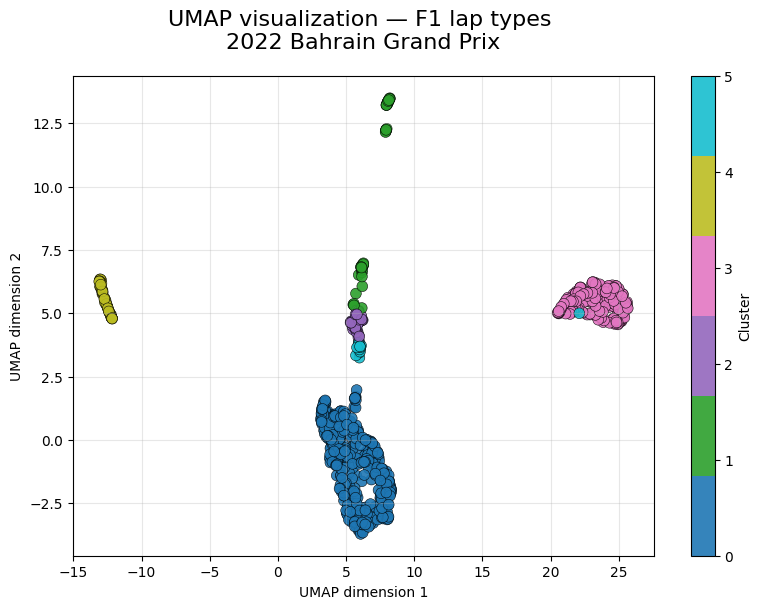

In [49]:
import umap

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

cmap = plt.get_cmap('tab10', 6)

embedding = reducer.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                     c=df['cluster'], cmap=cmap, s=60, alpha=0.9, edgecolor='k', linewidth=0.4)
plt.title('UMAP visualization — F1 lap types \n2022 Bahrain Grand Prix', 
          fontsize=16, pad=20)
plt.colorbar(scatter, ticks=range(6), label='Cluster')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.show()

In [39]:
summary = df.groupby('cluster')[['LapTime','Sector1Time','Sector2Time','Sector3Time',
                                            'SpeedST','TyreLife']].median().round(2)

summary['count'] = df['cluster'].value_counts().sort_index()
summary = summary.sort_index()

summary

,LapTime,Sector1Time,Sector2Time,Sector3Time,SpeedST,TyreLife,count
cluster,,,,,,,
0,99.72,31.76,43.27,24.60,296.0,10.0,376
1,120.06,53.12,42.76,24.12,218.0,1.0,53
2,135.94,42.09,57.44,34.34,222.0,6.5,46
3,99.57,31.65,43.34,24.48,296.0,8.0,193
4,99.20,31.69,43.03,24.37,295.5,8.0,52
5,118.84,33.41,47.04,35.02,277.5,5.0,16


In [41]:
print(f"Max Tyre Life in dataset: {df['TyreLife'].max()}")

Max Tyre Life in dataset: 24.0


In [40]:
name_map = {
    0: "Standard Race Pace",
    1: "Pit Exit (Out-Lap)",
    2: "Safety Car / Cool Down",
    3: "Fast Race Pace",
    4: "Fastest / Push Lap",
    5: "Pit Entry (In-Lap)"
}

summary['Lap Type'] = summary.index.map(name_map)

final_view = summary[['Lap Type', 'count', 'SpeedST', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'TyreLife']]
final_view

,Lap Type,count,SpeedST,LapTime,Sector1Time,Sector2Time,Sector3Time,TyreLife
cluster,,,,,,,,
0,Standard Race Pace,376,296.0,99.72,31.76,43.27,24.60,10.0
1,Pit Exit (Out-Lap),53,218.0,120.06,53.12,42.76,24.12,1.0
2,Safety Car / Cool Down,46,222.0,135.94,42.09,57.44,34.34,6.5
3,Fast Race Pace,193,296.0,99.57,31.65,43.34,24.48,8.0
4,Fastest / Push Lap,52,295.5,99.20,31.69,43.03,24.37,8.0
5,Pit Entry (In-Lap),16,277.5,118.84,33.41,47.04,35.02,5.0


### Conclusion

This study demonstrated that unsupervised machine learning can successfully reverse-engineer the complex strategic narrative of a Formula 1 Grand Prix using only raw telemetry data.

1.  **The Strategic Hierarchy**
    The model revealed that a race is not just "fast" vs. "slow" laps, but a structured hierarchy of six behavioral modes:
    * **The Performance Window:** We identified a distinct **"Push Lap"** mode (Cluster 4) where drivers gained **0.3s in Sector 2** compared to standard racing, proving that peak performance is defined by cornering risk rather than straight-line speed.
    * **The Management Baseline:** The majority of the race (Cluster 0) was identified as **"Standard Race Pace,"** representing the consistent baseline for stint management.
    * **Operational Signatures:** The model successfully isolated pit stops through telemetry, capturing the specific deceleration profile of a **Pit Entry** (Cluster 5) and the acceleration deficit of a cold-tyre **Pit Exit** (Cluster 1).

2.  **Dimensionality Reduction**
    We demonstrated that the complexity of a Grand Prix can be compressed into two definable axes without feature engineering. The PCA projection autonomously separated:
    * **The "Performance Axis" (PC1):** Distinguishing racing intent from operational procedures.
    * **The "Strategic Axis" (PC2):** Identifying tyre compound usage based solely on vehicle dynamics.

3.  **Future Application**
    * **Live Anomaly Detection:** Instantly flagging laps that deviate from their expected cluster (e.g., a "Standard Pace" lap that suddenly drops into "Slow/Cool-down" telemetry).
    * **Driver Profiling:** Comparing how different drivers distribute their laps between **"Push"** (Cluster 4) and **"Conserve"** (Cluster 3) to quantify driving styles.